In [1]:
import wandb
import os
import pickle
import shutil
from pathlib import Path
from typing import List, Union


def get_runs(user="", project="", query={}, **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    return runs
    #dataframes = [run.history(**kwargs) for run in runs]
    #return list(zip(runs, dataframes))

In [2]:
# Imbalanced CIFAR
queries = {}

## Xent rw minority
queries["xent-min"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_minority_ermrw"}
             ]
})

## Xent rw majority
queries["xent-maj"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_majority_ermrw"}
             ]
})

## Xent rw both
queries["xent-both"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_n_ermrw"}
             ]
})

## VSloss majority
queries["vs-maj"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_majority_vsloss"}
             ]
})

## VSloss both
queries["vs-both"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_n_vsloss"}
             ]
})


# VSloss minority
queries["vs-min"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_minority_vsloss"}
             ]
})

## tiltedloss majority
queries["tilted-maj"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_majority_tiltedloss"}
             ]
})

## tiltedloss both
queries["tilted-both"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_n_tiltedloss"}
             ]
})


# tiltedloss minority
queries["tilted-min"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_minority_tiltedloss"}
             ]
})

## DRO majority
queries["dro-maj"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_majority_dro"}
             ]
})

## DRO both
queries["dro-both"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_n_dro"}
             ]
})


# DRO minority
queries["dro-min"] = ("iclr-time-score-dre",
    {"$and": [{"state": "finished"},
              {"group": "cifar_scaling_minority_dro"}
             ]
})

In [3]:
def parse_run(run):
    config = run.config
    df = run.history(keys=["test/test_reweighted_acc", "test/worst_group_acc"])
    
    acc = df["test/test_reweighted_acc"].dropna().iloc[0] # there should only be one logged
    worst_acc = df["test/worst_group_acc"].dropna().iloc[0] # there should only be one logged
    assert acc > 0.
    stats = {
    #    "name": run.name,
    #    "loss": config["loss_fn/_target_"],
    #    "dataset": config["datamodule/group_datamodule_cls_name"],
        "seed": config["seed"],
        "acc": acc,
   #     "worst_acc": worst_acc,
        "majority_samples": config["datamodule/class_samples"][0],
        "minority_samples": config["datamodule/class_samples"][1],
    }
    return stats

In [4]:
stats_list = []
for query_name, user__query in queries.items():
    user, query = user__query
    project = "importance-reweighing"
    runs = get_runs(user=user, project=project, query=query)
    stats_of_runs = [parse_run(run) for run in runs]
    
    for stats in stats_of_runs:
        stats["query"] = query_name
    
    stats_list += stats_of_runs

In [5]:
import pandas as pd

df = pd.DataFrame(stats_list)
#df = df[(df["loss"] == "torch.nn.CrossEntropyLoss") ]

In [6]:
df.shape

(260, 5)

In [9]:
df.groupby("query").count()

,seed,acc,majority_samples,minority_samples
query,,,,
dro-both,25,25,25,25
dro-maj,20,20,20,20
dro-min,20,20,20,20
tilted-both,25,25,25,25
tilted-maj,20,20,20,20
tilted-min,20,20,20,20
vs-both,25,25,25,25
vs-maj,20,20,20,20
vs-min,20,20,20,20


In [10]:
df

,seed,acc,majority_samples,minority_samples,query
0,4,0.6500,2500,2000,xent-min
1,4,0.6240,2500,1500,xent-min
2,4,0.5925,2500,500,xent-min
3,3,0.6600,2500,1500,xent-min
4,3,0.6475,2500,1000,xent-min
...,...,...,...,...,...
255,0,0.6995,2500,2000,dro-min
256,0,0.6905,2500,1500,dro-min
257,1,0.6360,2500,500,dro-min
258,1,0.6460,2500,1000,dro-min


In [11]:
old_names = ['xent-min', 'xent-maj', 'xent-both','vs-min','vs-maj','vs-both',
             'tilted-min','tilted-maj','tilted-both','dro-min','dro-maj','dro-both']
new_names = ['CE-IW Minority', 'CE-IW Majority', 'CE-IW Both','VS Minority','VS Majority','VS Both',
            'Tilted Minority','Tilted Majority','Tilted Both','DRO Minority','DRO Majority','DRO Both']
for old, new in zip(old_names, new_names):
    df["query"] = df["query"].replace(old, new)

In [12]:
def get_corners(rectangle):
    b = rectangle
    w,h = b.get_width(), b.get_height()
    # lower left vertex
    x0, y0 = b.xy
    # lower right vertex
    x1, y1 = x0 + w, y0
    # top left vertex
    x2, y2 = x0, y0 + h
    # top right vertex
    x3, y3 = x0 + w, y0 + h
    return (x0,y0), (x1,y1), (x2,y2), (x3,y3)

In [13]:
def outline_bracket(left_bar, right_bar, spacing, height):
    l0, l1, l2, l3 = get_corners(left_bar)
    r0, r1, r2, r3 = get_corners(right_bar)
    
    # lower left
    b0 = ((l0[0] + l1[0]) / 2, max(l2[1], r2[1]) + spacing)
    # upper left
    b1 = (b0[0], max(l2[1] + spacing, r2[1] + spacing) + height)
    # upper right
    b2 = ((r0[0] + r1[0]) / 2, b1[1])
    # lower right
    b3 = (b2[0], b0[1])
    return b0, b1, b2, b3

In [14]:
df

,seed,acc,majority_samples,minority_samples,query
0,4,0.6500,2500,2000,CE-IW Minority
1,4,0.6240,2500,1500,CE-IW Minority
2,4,0.5925,2500,500,CE-IW Minority
3,3,0.6600,2500,1500,CE-IW Minority
4,3,0.6475,2500,1000,CE-IW Minority
...,...,...,...,...,...
255,0,0.6995,2500,2000,DRO Minority
256,0,0.6905,2500,1500,DRO Minority
257,1,0.6360,2500,500,DRO Minority
258,1,0.6460,2500,1000,DRO Minority


In [35]:
import numpy as np
df_interp = df.copy()

# CE-IW-ES results
df_minority = df[(df["query"] == "CE-IW Minority") ]
df_majority = df[(df["query"] == "CE-IW Majority") ]
df_both = df[(df["query"] == "CE-IW Both") ]

ce_iw_min = pd.DataFrame.to_numpy(df_minority)
ce_iw_maj = pd.DataFrame.to_numpy(df_majority)
ce_iw_both = pd.DataFrame.to_numpy(df_both)


ce_iw_min = ce_iw_min[ce_iw_min[:, 3].argsort()]  # sort by minority samples
ce_iw_maj = ce_iw_maj[ce_iw_maj[:, 2].argsort()]  # sort by majority samples
ce_iw_both = ce_iw_both[ce_iw_both[:, 2].argsort()]  # sort by majority samples


ce_iw_maj = np.vstack([ce_iw_min[0:5,:],ce_iw_maj])
ce_iw_both = np.vstack([ce_iw_min[0:5,:],ce_iw_both])

ce_iw_min_avg=np.zeros(4)
ce_iw_maj_avg=np.zeros(5)
ce_iw_both_avg=np.zeros(6)

ce_iw_min_std=np.zeros(4)
ce_iw_maj_std=np.zeros(5)
ce_iw_both_std=np.zeros(6)

for i in range(4):
    # calculate mean
    ce_iw_min_avg[i] = np.mean(ce_iw_min[5*i:(5*i+5),1])
    ce_iw_maj_avg[i] = np.mean(ce_iw_maj[5*i:(5*i+5),1])
    ce_iw_both_avg[i] = np.mean(ce_iw_both[5*i:(5*i+5),1])
    # calculate sd
    ce_iw_min_std[i] = 1.645*np.std(ce_iw_min[5*i:(5*i+5),1],ddof=1)/np.sqrt(len(ce_iw_min[5*i:(5*i+5),1]))
    ce_iw_maj_std[i] = 1.645*np.std(ce_iw_maj[5*i:(5*i+5),1],ddof=1)/np.sqrt(len(ce_iw_maj[5*i:(5*i+5),1]))
    ce_iw_both_std[i] = 1.645*np.std(ce_iw_both[5*i:(5*i+5),1],ddof=1)/np.sqrt(len(ce_iw_both[5*i:(5*i+5),1]))
    

ce_iw_maj_avg[4] = np.mean(ce_iw_maj[20:25,1])
ce_iw_both_avg[4] = np.mean(ce_iw_both[20:25,1])
ce_iw_both_avg[5] = np.mean(ce_iw_both[25:30,1])


ce_iw_maj_std[4] = 1.645*np.std(ce_iw_maj[20:25,1],ddof=1)/np.sqrt(len(ce_iw_maj[20:25,1]))
ce_iw_both_std[4] = 1.645*np.std(ce_iw_both[20:25,1],ddof=1)/np.sqrt(len(ce_iw_both[20:25,1]))
ce_iw_both_std[5] = 1.645*np.std(ce_iw_both[25:30,1],ddof=1)/np.sqrt(len(ce_iw_both[25:30,1]))



# VS Loss results
df_minority = df[(df["query"] == "VS Minority") ]
df_majority = df[(df["query"] == "VS Majority") ]
df_both = df[(df["query"] == "VS Both") ]

vs_min = pd.DataFrame.to_numpy(df_minority)
vs_maj = pd.DataFrame.to_numpy(df_majority)
vs_both = pd.DataFrame.to_numpy(df_both)

vs_min = vs_min[vs_min[:, 3].argsort()]  # sort by minority samples
vs_maj = vs_maj[vs_maj[:, 2].argsort()]  # sort by majority samples
vs_both = vs_both[vs_both[:, 2].argsort()]  # sort by majority samples

vs_maj = np.vstack([vs_min[0:5,:],vs_maj])
vs_both = np.vstack([vs_min[0:5,:],vs_both])


vs_min_avg=np.zeros(4)
vs_maj_avg=np.zeros(5)
vs_both_avg=np.zeros(6)

vs_min_std=np.zeros(4)
vs_maj_std=np.zeros(5)
vs_both_std=np.zeros(6)

for i in range(4):
    vs_min_avg[i] = np.mean(vs_min[5*i:(5*i+5),1])
    vs_maj_avg[i] = np.mean(vs_maj[5*i:(5*i+5),1])
    vs_both_avg[i] = np.mean(vs_both[5*i:(5*i+5),1])
    # calculate sd
    vs_min_std[i] = 1.645*np.std(vs_min[5*i:(5*i+5),1],ddof=1)/np.sqrt(len(vs_min[5*i:(5*i+5),1]))
    vs_maj_std[i] = 1.645*np.std(vs_maj[5*i:(5*i+5),1],ddof=1)/np.sqrt(len(vs_maj[5*i:(5*i+5),1]))
    vs_both_std[i] = 1.645*np.std(vs_both[5*i:(5*i+5),1],ddof=1)/np.sqrt(len(vs_both[5*i:(5*i+5),1]))

vs_maj_avg[4] = np.mean(vs_maj[20:25,1])
vs_both_avg[4] = np.mean(vs_both[20:25,1])
vs_both_avg[5] = np.mean(vs_both[25:30,1])

vs_maj_std[4] = 1.645*np.std(vs_maj[20:25,1],ddof=1)/np.sqrt(len(vs_maj[20:25,1]))
vs_both_std[4] = 1.645*np.std(vs_both[20:25,1],ddof=1)/np.sqrt(len(vs_both[20:25,1]))
vs_both_std[5] = 1.645*np.std(vs_both[25:30,1],ddof=1)/np.sqrt(len(vs_both[25:30,1]))

In [36]:
# Tilted results
df_minority = df[(df["query"] == "Tilted Minority") ]
df_majority = df[(df["query"] == "Tilted Majority") ]
df_both = df[(df["query"] == "Tilted Both") ]

tilted_min = pd.DataFrame.to_numpy(df_minority)
tilted_maj = pd.DataFrame.to_numpy(df_majority)
tilted_both = pd.DataFrame.to_numpy(df_both)


tilted_min = tilted_min[tilted_min[:, 3].argsort()]  # sort by minority samples
tilted_maj = tilted_maj[tilted_maj[:, 2].argsort()]  # sort by majority samples
tilted_both = tilted_both[tilted_both[:, 2].argsort()]  # sort by majority samples


tilted_maj = np.vstack([tilted_min[0:5,:],tilted_maj])
tilted_both = np.vstack([tilted_min[0:5,:],tilted_both])

tilted_min_avg=np.zeros(4)
tilted_maj_avg=np.zeros(5)
tilted_both_avg=np.zeros(6)

for i in range(4):
    tilted_min_avg[i] = np.mean(tilted_min[5*i:(5*i+5),1])
    tilted_maj_avg[i] = np.mean(tilted_maj[5*i:(5*i+5),1])
    tilted_both_avg[i] = np.mean(tilted_both[5*i:(5*i+5),1])

tilted_maj_avg[4] = np.mean(tilted_maj[20:25,1])
tilted_both_avg[4] = np.mean(tilted_both[20:25,1])
tilted_both_avg[5] = np.mean(tilted_both[25:30,1])

# VS Loss results
df_minority = df[(df["query"] == "DRO Minority") ]
df_majority = df[(df["query"] == "DRO Majority") ]
df_both = df[(df["query"] == "DRO Both") ]

dro_min = pd.DataFrame.to_numpy(df_minority)
dro_maj = pd.DataFrame.to_numpy(df_majority)
dro_both = pd.DataFrame.to_numpy(df_both)

dro_min = dro_min[dro_min[:, 3].argsort()]  # sort by minority samples
dro_maj = dro_maj[dro_maj[:, 2].argsort()]  # sort by majority samples
dro_both = dro_both[dro_both[:, 2].argsort()]  # sort by majority samples

dro_maj = np.vstack([dro_min[0:5,:],dro_maj])
dro_both = np.vstack([dro_min[0:5,:],dro_both])


dro_min_avg=np.zeros(4)
dro_maj_avg=np.zeros(5)
dro_both_avg=np.zeros(6)

for i in range(4):
    dro_min_avg[i] = np.mean(dro_min[5*i:(5*i+5),1])
    dro_maj_avg[i] = np.mean(dro_maj[5*i:(5*i+5),1])
    dro_both_avg[i] = np.mean(dro_both[5*i:(5*i+5),1])

dro_maj_avg[4] = np.mean(dro_maj[20:25,1])
dro_both_avg[4] = np.mean(dro_both[20:25,1])
dro_both_avg[5] = np.mean(dro_both[25:30,1])

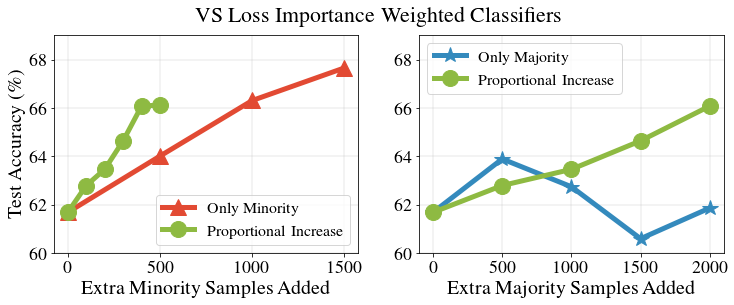

In [39]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FormatStrFormatter

palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)


plt.rc('text', usetex=True)
#style.use('fivethirtyeight')
plt.rc('font', family='times')
#csfont = {'fontname':'Times New Roman'}
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

minority_samples=[0,500,1000,1500]
minority_samples_both=[0,100,200,300,400,500]
majority_samples=[0,500,1000,1500,2000]
majority_samples_both=[0,500,1000,1500,2000]

fig = plt.figure(figsize=(12, 4))
fig.set_facecolor('white')
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_facecolor("#e1ddbf")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.set_facecolor("#e1ddbf")
plt.locator_params(axis="y", nbins=6)

ax1.plot(minority_samples,100*vs_min_avg,'^',markersize = 16,markevery=1,linewidth=5,label="Only Minority",linestyle='solid')
#ax1.fill_between(minority_samples, 100*vs_min_avg-100*vs_min_std, 100*vs_min_avg+100*vs_min_std,alpha=0.1)
ax1.plot(minority_samples_both,100*vs_both_avg,'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')
#ax1.fill_between(minority_samples_both, 100*vs_both_avg-100*vs_both_std, 100*vs_both_avg+100*vs_both_std,alpha=0.1)


ax2.plot(majority_samples,100*vs_maj_avg,'*',markersize = 16,markevery=1,linewidth=5,
                             label="Only Majority",linestyle='solid',color='#348ABD')
ax2.plot(majority_samples_both,100*vs_both_avg[:5],'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')
#ax1.plot(poly_both[:,0],'*',markersize = 18,markevery=2,linewidth=5,label="Overall",linestyle='solid')
#ax1.vlines(1, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.vlines(3, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')


ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax1.grid(True, linewidth=0.3)
ax2.grid(True, linewidth=0.3)

ax1.set_xlabel('Extra Minority Samples Added',size=20)
ax2.set_xlabel('Extra Majority Samples Added',size=20)
#ax1.set_xticks([0, 1, 2, 3, 4, 5])

ax1.set_ylim(60, 69)
ax2.set_ylim(60, 69)

fig.suptitle('VS Loss Importance Weighted Classifiers', fontsize=22)
ax1.set_ylabel("Test Accuracy (\%)",size=20)
#ax1.set_title("Test Error vs. Importance Weight " r'$(w=\tau^{\rho})$',size=18)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
#handles = [handles[1], handles[2], handles[0]]
#labels = [labels[1], labels[2], labels[0]]
ax1.legend(handles1, labels1, loc='lower right',prop={'size': 16},facecolor='white')
ax2.legend(handles2, labels2, loc='upper left',prop={'size': 16},facecolor='white')
#ax1.legend(loc='best',prop={'size': 12},facecolor='white')
plt.savefig('vs_loss.png', bbox_inches='tight',dpi=1000)
plt.show()

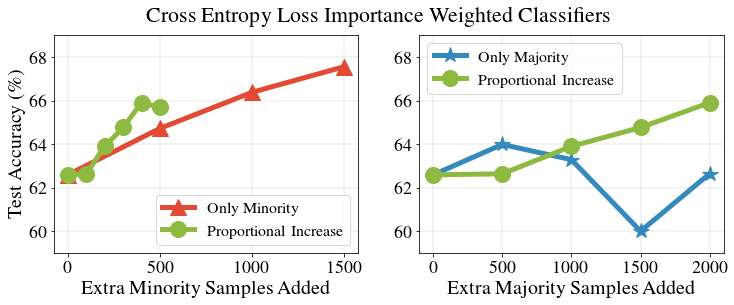

In [18]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FormatStrFormatter

palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)


plt.rc('text', usetex=True)
#style.use('fivethirtyeight')
plt.rc('font', family='times')
#csfont = {'fontname':'Times New Roman'}
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

minority_samples=[0,500,1000,1500]
minority_samples_both=[0,100,200,300,400,500]
majority_samples=[0,500,1000,1500,2000]
majority_samples_both=[0,500,1000,1500,2000]

fig = plt.figure(figsize=(12, 4))
fig.set_facecolor('white')
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_facecolor("#e1ddbf")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.set_facecolor("#e1ddbf")
plt.locator_params(axis="y", nbins=6)

ax1.plot(minority_samples,100*ce_iw_min_avg,'^',markersize = 16,markevery=1,linewidth=5,label="Only Minority",linestyle='solid')
ax1.plot(minority_samples_both,100*ce_iw_both_avg,'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')


ax2.plot(majority_samples,100*ce_iw_maj_avg,'*',markersize = 16,markevery=1,linewidth=5,
                             label="Only Majority",linestyle='solid',color='#348ABD')
ax2.plot(majority_samples_both,100*ce_iw_both_avg[:5],'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')
#ax1.plot(poly_both[:,0],'*',markersize = 18,markevery=2,linewidth=5,label="Overall",linestyle='solid')
#ax1.vlines(1, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.vlines(3, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')


ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax1.grid(True, linewidth=0.3)
ax2.grid(True, linewidth=0.3)
ax1.set_ylim(59, 69)
ax2.set_ylim(59, 69)

ax1.set_xlabel('Extra Minority Samples Added',size=20)
ax2.set_xlabel('Extra Majority Samples Added',size=20)
#ax1.set_xticks([0, 1, 2, 3, 4, 5])

fig.suptitle('Cross Entropy Loss Importance Weighted Classifiers', fontsize=22)
ax1.set_ylabel("Test Accuracy (\%)",size=20)
#ax1.set_title("Test Error vs. Importance Weight " r'$(w=\tau^{\rho})$',size=18)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
#handles = [handles[1], handles[2], handles[0]]
#labels = [labels[1], labels[2], labels[0]]
ax1.legend(handles1, labels1, loc='lower right',prop={'size': 16},facecolor='white')
ax2.legend(handles2, labels2, loc='upper left',prop={'size': 16},facecolor='white')
#ax1.legend(loc='best',prop={'size': 12},facecolor='white')
plt.savefig('ce_loss.png', bbox_inches='tight',dpi=1000)
plt.show()

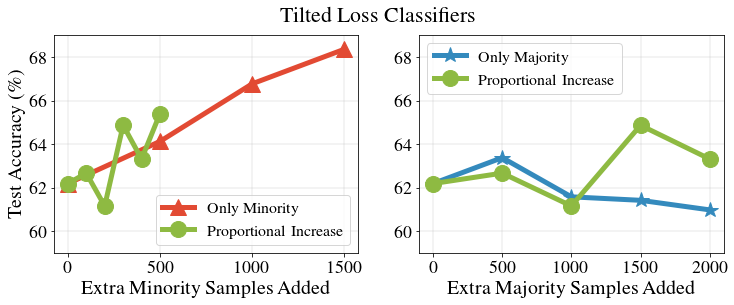

In [19]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FormatStrFormatter

palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)


plt.rc('text', usetex=True)
#style.use('fivethirtyeight')
plt.rc('font', family='times')
#csfont = {'fontname':'Times New Roman'}
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

minority_samples=[0,500,1000,1500]
minority_samples_both=[0,100,200,300,400,500]
majority_samples=[0,500,1000,1500,2000]
majority_samples_both=[0,500,1000,1500,2000]

fig = plt.figure(figsize=(12, 4))
fig.set_facecolor('white')
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_facecolor("#e1ddbf")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.set_facecolor("#e1ddbf")
plt.locator_params(axis="y", nbins=6)

ax1.plot(minority_samples,100*tilted_min_avg,'^',markersize = 16,markevery=1,linewidth=5,label="Only Minority",linestyle='solid')
ax1.plot(minority_samples_both,100*tilted_both_avg,'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')


ax2.plot(majority_samples,100*tilted_maj_avg,'*',markersize = 16,markevery=1,linewidth=5,
                             label="Only Majority",linestyle='solid',color='#348ABD')
ax2.plot(majority_samples_both,100*tilted_both_avg[:5],'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')
#ax1.plot(poly_both[:,0],'*',markersize = 18,markevery=2,linewidth=5,label="Overall",linestyle='solid')
#ax1.vlines(1, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.vlines(3, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')


ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax1.grid(True, linewidth=0.3)
ax2.grid(True, linewidth=0.3)
ax1.set_ylim(59, 69)
ax2.set_ylim(59, 69)

ax1.set_xlabel('Extra Minority Samples Added',size=20)
ax2.set_xlabel('Extra Majority Samples Added',size=20)
#ax1.set_xticks([0, 1, 2, 3, 4, 5])

fig.suptitle('Tilted Loss Classifiers', fontsize=22)
ax1.set_ylabel("Test Accuracy (\%)",size=20)
#ax1.set_title("Test Error vs. Importance Weight " r'$(w=\tau^{\rho})$',size=18)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
#handles = [handles[1], handles[2], handles[0]]
#labels = [labels[1], labels[2], labels[0]]
ax1.legend(handles1, labels1, loc='lower right',prop={'size': 16},facecolor='white')
ax2.legend(handles2, labels2, loc='upper left',prop={'size': 16},facecolor='white')
#ax1.legend(loc='best',prop={'size': 12},facecolor='white')
plt.savefig('tilted_loss.png', bbox_inches='tight',dpi=1000)
plt.show()

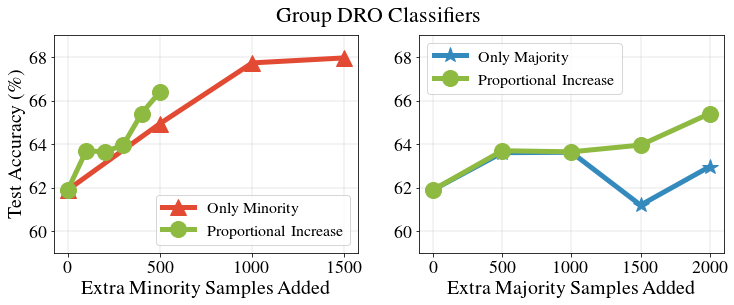

In [20]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.ticker import FormatStrFormatter

palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)


plt.rc('text', usetex=True)
#style.use('fivethirtyeight')
plt.rc('font', family='times')
#csfont = {'fontname':'Times New Roman'}
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)

minority_samples=[0,500,1000,1500]
minority_samples_both=[0,100,200,300,400,500]
majority_samples=[0,500,1000,1500,2000]
majority_samples_both=[0,500,1000,1500,2000]

fig = plt.figure(figsize=(12, 4))
fig.set_facecolor('white')
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.set_facecolor("#e1ddbf")
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax2.set_facecolor("#e1ddbf")
plt.locator_params(axis="y", nbins=6)

ax1.plot(minority_samples,100*dro_min_avg,'^',markersize = 16,markevery=1,linewidth=5,label="Only Minority",linestyle='solid')
ax1.plot(minority_samples_both,100*dro_both_avg,'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')


ax2.plot(majority_samples,100*dro_maj_avg,'*',markersize = 16,markevery=1,linewidth=5,
                             label="Only Majority",linestyle='solid',color='#348ABD')
ax2.plot(majority_samples_both,100*dro_both_avg[:5],'o',markersize = 16,markevery=1,linewidth=5,
                             label= "Proportional Increase",linestyle='solid',color='#8EBA42')
#ax1.plot(poly_both[:,0],'*',markersize = 18,markevery=2,linewidth=5,label="Overall",linestyle='solid')
#ax1.vlines(1, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.vlines(3, 0, 20,linestyle='dashed',alpha=0.3,color='teal')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')
#ax1.plot(a_vals,100*avg_n_perfs,'o',markersize = 10,linewidth=4,label= "Minority Class Error",linestyle='dashdot')


ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax1.grid(True, linewidth=0.3)
ax2.grid(True, linewidth=0.3)
ax1.set_ylim(59, 69)
ax2.set_ylim(59, 69)

ax1.set_xlabel('Extra Minority Samples Added',size=20)
ax2.set_xlabel('Extra Majority Samples Added',size=20)
#ax1.set_xticks([0, 1, 2, 3, 4, 5])

fig.suptitle('Group DRO Classifiers', fontsize=22)
ax1.set_ylabel("Test Accuracy (\%)",size=20)
#ax1.set_title("Test Error vs. Importance Weight " r'$(w=\tau^{\rho})$',size=18)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
#handles = [handles[1], handles[2], handles[0]]
#labels = [labels[1], labels[2], labels[0]]
ax1.legend(handles1, labels1, loc='lower right',prop={'size': 16},facecolor='white')
ax2.legend(handles2, labels2, loc='upper left',prop={'size': 16},facecolor='white')
#ax1.legend(loc='best',prop={'size': 12},facecolor='white')
plt.savefig('dro_loss.png', bbox_inches='tight',dpi=1000)
plt.show()

In [23]:
len(ce_iw_min[5*i:(5*i+5),1])

5

In [33]:
vs_both_std

array([0.02190819, 0.01936436, 0.02510098, 0.02803451, 0.01740597,
       0.01172974])